<a href="https://colab.research.google.com/github/bvu36/vuong598/blob/main/vuong598project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1] loss: 4.051


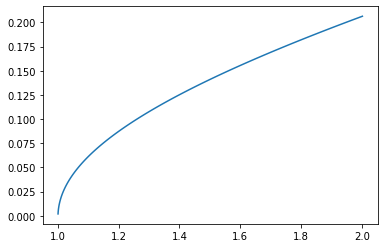

[2] loss: 1.924


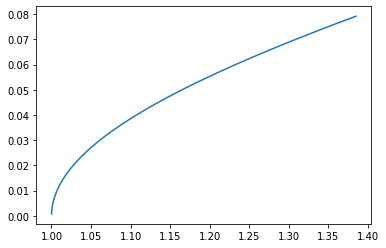

[3] loss: 1.086


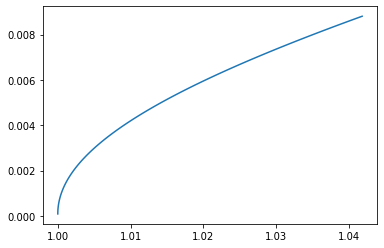

[4] loss: 0.657


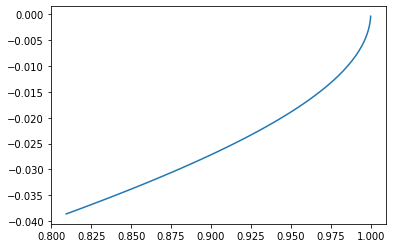

[5] loss: 0.414


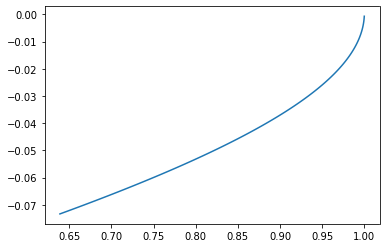

[6] loss: 0.267


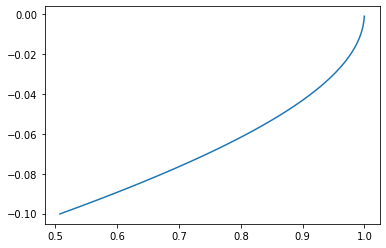

[7] loss: 0.177


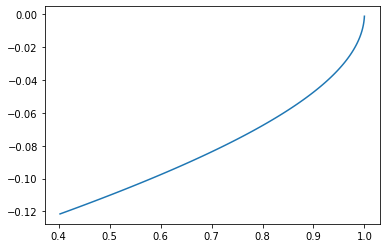

[8] loss: 0.121


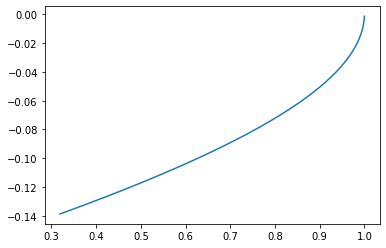

[9] loss: 0.087


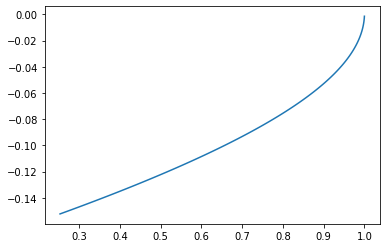

[10] loss: 0.067


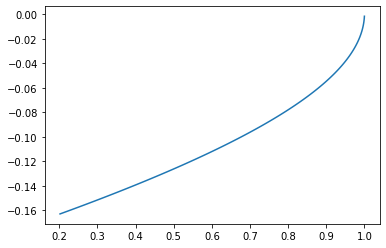

[11] loss: 0.056


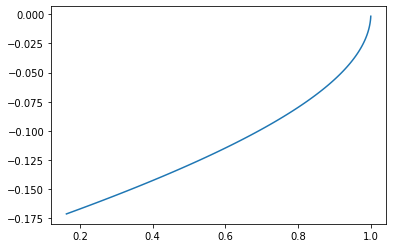

[12] loss: 0.049


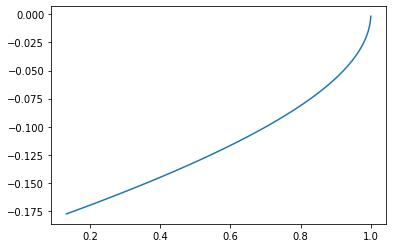

[13] loss: 0.045


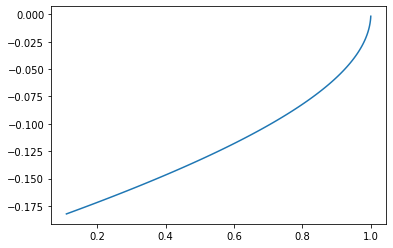

[14] loss: 0.043


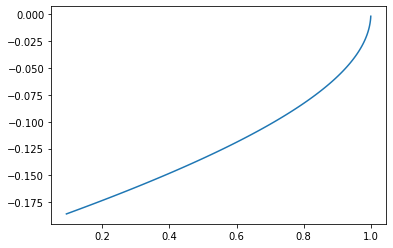

[15] loss: 0.042


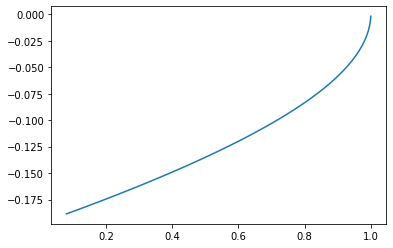

[16] loss: 0.041


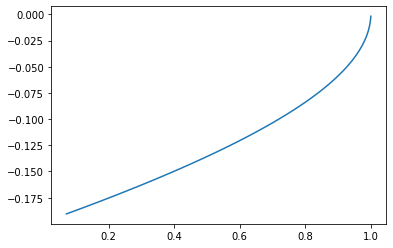

[17] loss: 0.041


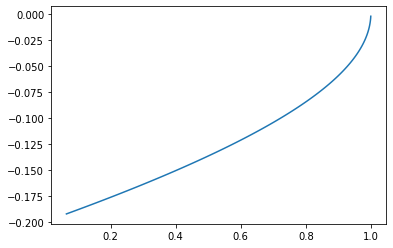

[18] loss: 0.041


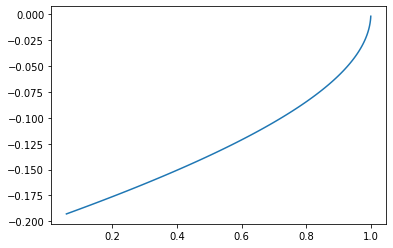

[19] loss: 0.040


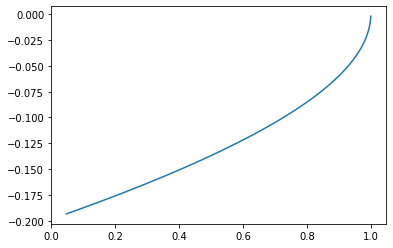

[20] loss: 0.039


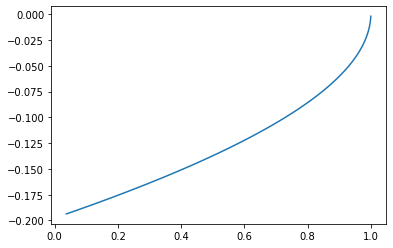

[21] loss: 0.038


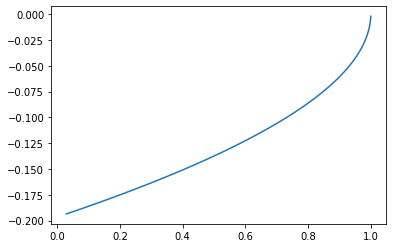

[22] loss: 0.032


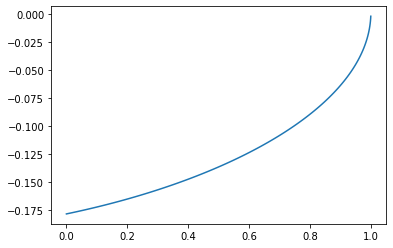

[23] loss: 0.021


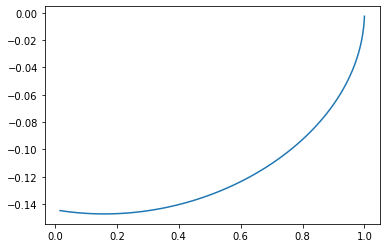

[24] loss: 0.011


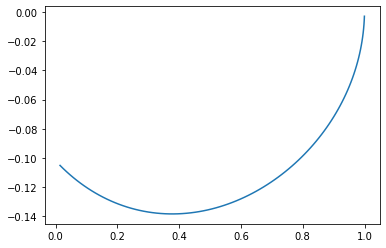

[25] loss: 0.002


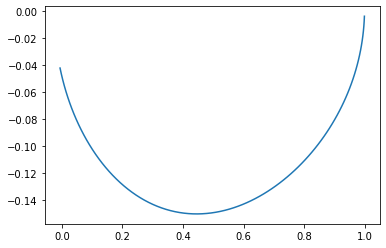

[26] loss: 0.001


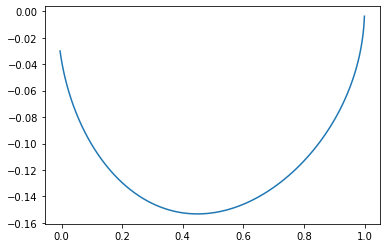

[27] loss: 0.000


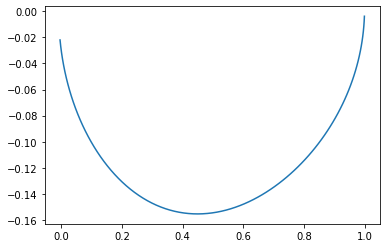

[28] loss: 0.000


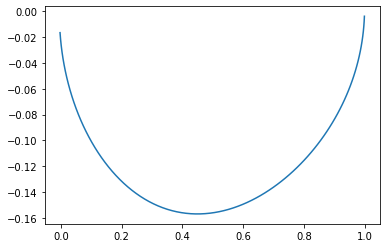

[29] loss: 0.000


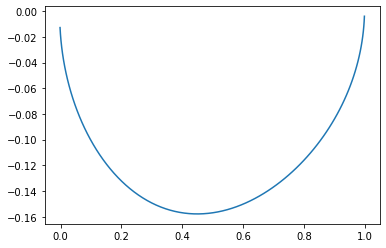

[30] loss: 0.000


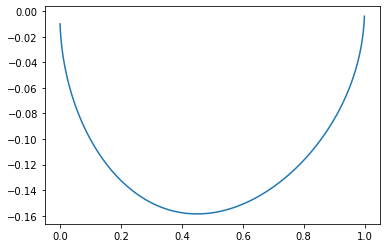

[31] loss: 0.000


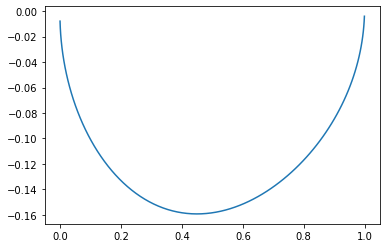

[32] loss: 0.000


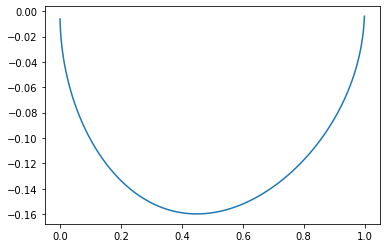

[33] loss: 0.000


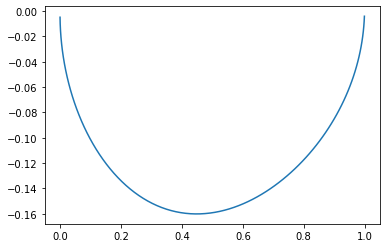

[34] loss: 0.000


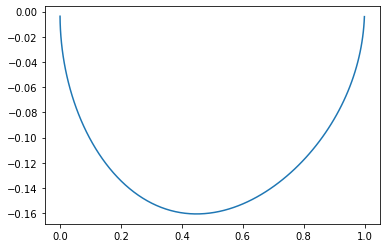

[35] loss: 0.000


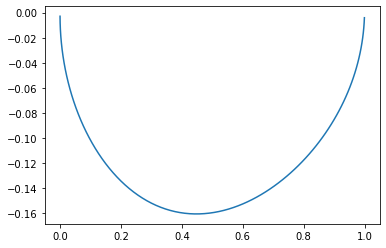

[36] loss: 0.000


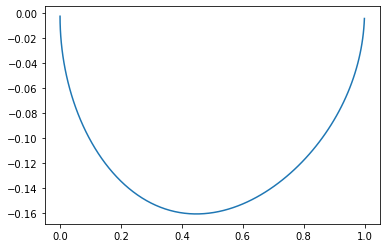

[37] loss: 0.000


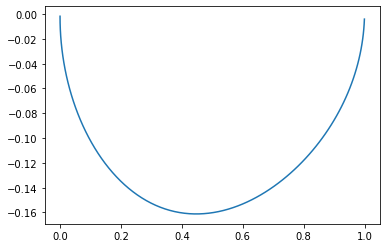

[38] loss: 0.000


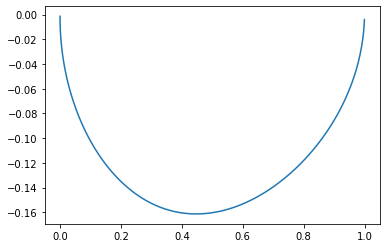

[39] loss: 0.000


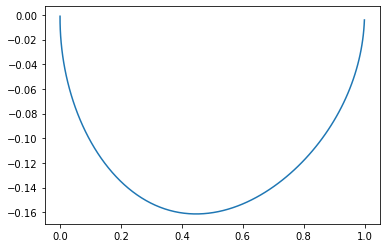

[40] loss: 0.000


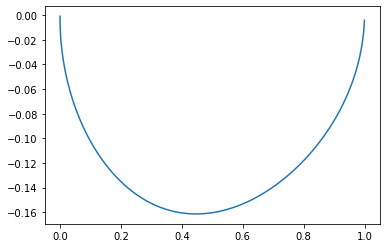

In [2]:
# Bryan Vuong
# MAE 598 Project 1
# Objective: Adding drag for a better dynamic model for rocket landing

# Assumptions: 
# Assume average model rocket dimensions with body length 0.69m and nose cone length 0.05m

# necessary imports
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# given environment variables ------------------------------------------
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant



# define system dynamics -------------------------------------------
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        # dynamics parameters
        """
        action: thrust or no thrust
        state[0] = y  
        state[1] = y_dot
       
        """
        # Drag variables
        # https://www.grc.nasa.gov/www/k-12/rocket/drageq.html
        # https://www.grc.nasa.gov/www/k-12/rocket/shaped.html#:~:text=A%20typical%20value%20for%20the,body%20and%20the%20nozzle%20exit.
        
        cd = 0.75 # drag coefficient for typical model rocket
        rho = 1.2065 # kg/m^3, air density at cape canaveral https://w1.weather.gov/data/obhistory/KXMR.html
        V = BOOST_ACCEL * FRAME_TIME # velocity
        A = 0.100985 # m^2, surface area of typical model rocket https://simplerocketry.com/how-big-are-model-rockets-avg-size-largest-smallest/
        D = cd * (0.5 * rho * (V ** 2) * A)
        drag = t.tensor([D]) # drag


        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)
        state = t.sub(state, drag) # subtracting drag from velocity
        return state


# deterministic controller -----------------------------------------
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


# simulator  ---------------------------------------------------------------
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2


# set up the optimizer -----------------------------------------------
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward() # gradient calculator
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]

        # plotting
        plt.plot(x, y)
        plt.show()


# Running the code ---------------------------------------

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem

# Analysis of Results -------------------------------------------
# According to the results, the minimum considering drag is similar to the minimum without considering drag
# which is around -0.15. 